In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Load the dataset
file_path = r"D:\Vegetables and Fruits\kalimati_tarkari_dataset.csv"
df = pd.read_csv(file_path)

In [4]:
#Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [5]:
#Sort by date
df = df.sort_values(by='Date')

In [6]:
#Filter data for a specific fruit (e.g., 'Tomato Big(Nepali)')
commodity = "Tomato Big(Nepali)"
df_fruit = df[df["Commodity"] == commodity]

In [7]:
#Set Date as index
df_fruit.set_index("Date", inplace=True)

In [8]:
#Keep only 'Average' price column
df_fruit = df_fruit[['Average']]

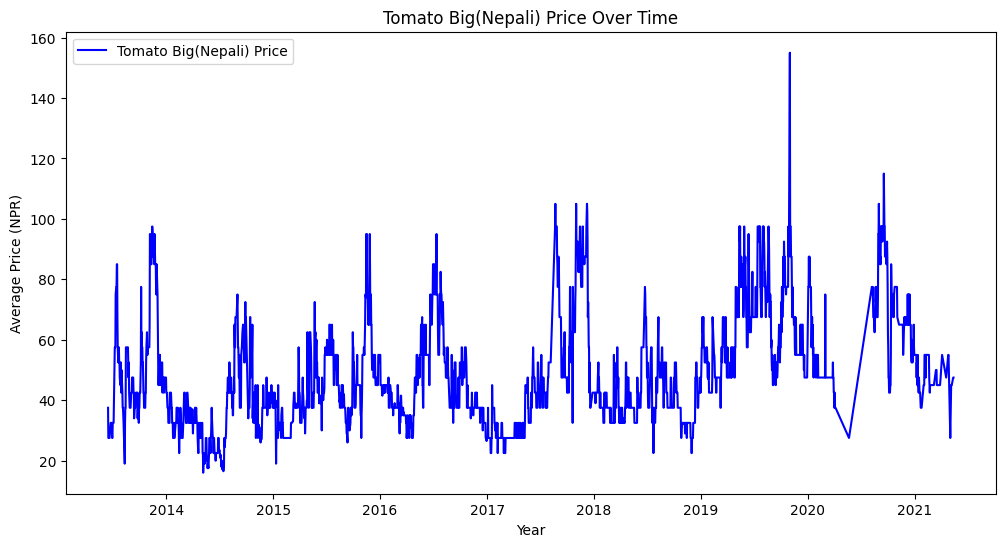

In [9]:
#Plot the price trend
plt.figure(figsize=(12, 6))
plt.plot(df_fruit, label=f"{commodity} Price", color='blue')
plt.title(f"{commodity} Price Over Time")
plt.xlabel("Year")
plt.ylabel("Average Price (NPR)")
plt.legend()
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

#Perform ADF test
result = adfuller(df_fruit['Average'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

#If p-value > 0.05, data is not stationary → Apply differencing
if result[1] > 0.05:
    df_fruit['Average_diff'] = df_fruit['Average'].diff().dropna()


ADF Statistic: -5.479952211062562
p-value: 2.2962180497055288e-06


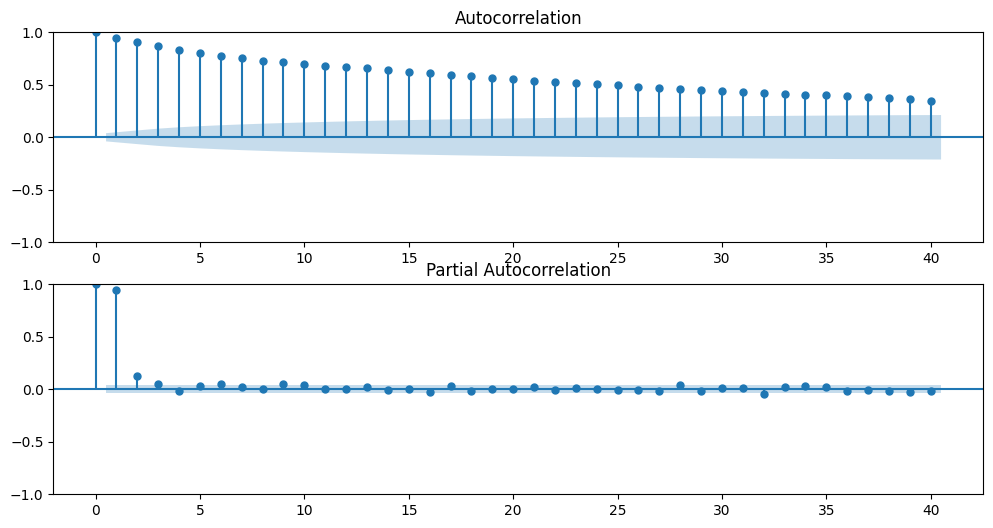

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#ACF and PACF plots
fig, ax = plt.subplots(2, figsize=(12, 6))
plot_acf(df_fruit['Average'].dropna(), ax=ax[0], lags=40)
plot_pacf(df_fruit['Average'].dropna(), ax=ax[1], lags=40)
plt.show()


We train the **SARIMA (Seasonal ARIMA)** model to capture trends and seasonality in the price data.  
- SARIMA is a statistical model that works well with seasonal data patterns.
- After fitting, SARIMA will predict future prices based on past trends.

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version

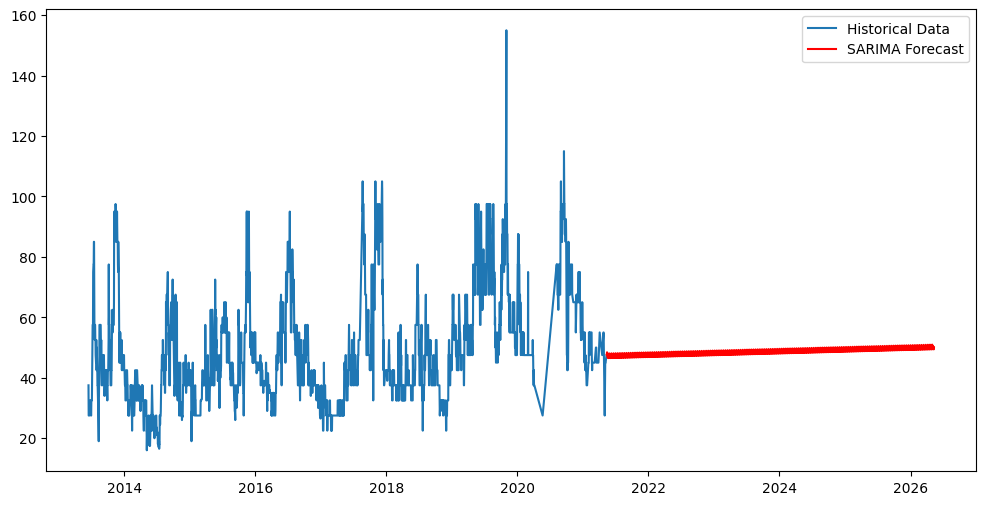

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Define SARIMA model (p,d,q) x (P,D,Q,S)
sarima_model = SARIMAX(df_fruit['Average'], 
                       order=(1, 1, 1),  #p, d, q
                       seasonal_order=(0, 1, 1, 12),  #P, D, Q, S (monthly seasonality)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

#Fit the model
sarima_result = sarima_model.fit()

#Forecast for 5 years (2027)
future_dates = pd.date_range(start=df_fruit.index[-1], periods=365*5, freq='D')
forecast_sarima = sarima_result.get_forecast(steps=len(future_dates))
forecast_df = pd.DataFrame({"Date": future_dates, "SARIMA_Forecast": forecast_sarima.predicted_mean})

#Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(df_fruit, label="Historical Data")
plt.plot(forecast_df["Date"], forecast_df["SARIMA_Forecast"], label="SARIMA Forecast", color='red')
plt.legend()
plt.show()


In [13]:
from sklearn.preprocessing import MinMaxScaler

#Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
df_fruit_scaled = scaler.fit_transform(df_fruit)

#Convert time series to supervised learning format
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

#Create sequences
time_steps = 30  #Use last 30 days to predict next day
X, y = create_sequences(df_fruit_scaled, time_steps)

#Split data into training & testing
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]


## 🔥 Training LSTM Model
We build a **Long Short-Term Memory (LSTM)** network for time series forecasting.  
- LSTM handles long-term dependencies better than traditional models.
- How will it be used?** The model will learn from historical price patterns and predict future values.

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.3),
    Dense(32),
    Dense(1)
])

#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train model
model.fit(X_train, y_train, epochs=150, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/150


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0140 - val_loss: 0.0065
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0040 - val_loss: 0.0054
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0034 - val_loss: 0.0050
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 6/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0027 - val_loss: 0.0041
Epoch 7/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 8/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 9/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 10/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 11/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 12/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━

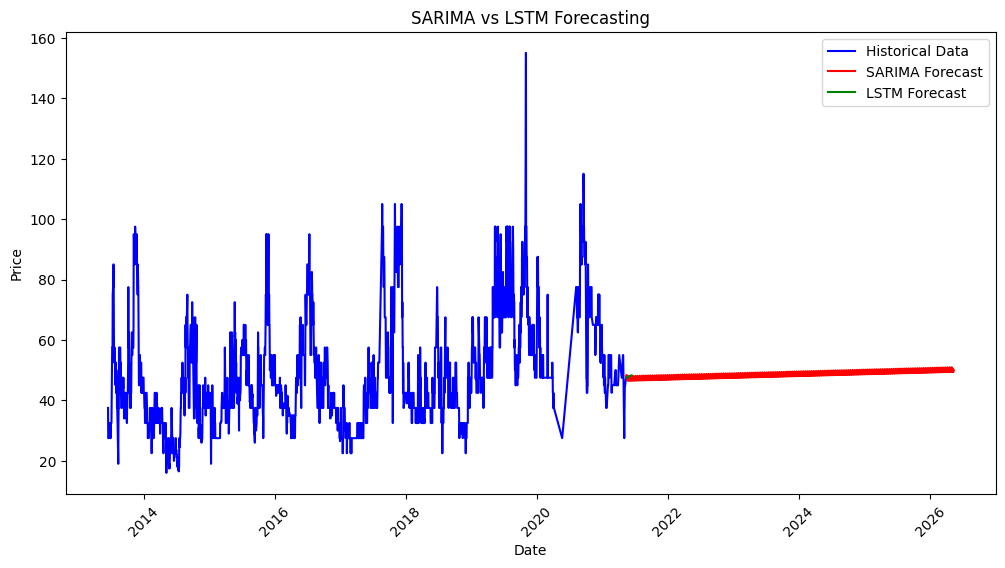

In [15]:
#Define future steps
future_steps = 30  #Predict next 30 days

#Predict on test data
y_pred = model.predict(X_test)

#Reverse normalization
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

#Forecast future prices
future_inputs = df_fruit_scaled[-time_steps:]
future_inputs = np.reshape(future_inputs, (1, time_steps, 1))

future_predictions = []  #Store future predictions

for _ in range(future_steps):
    pred = model.predict(future_inputs)
    pred = np.array(pred).reshape(1, 1, 1)  #Ensure correct shape
    future_inputs = np.concatenate((future_inputs[:, 1:, :], pred), axis=1)  #Append prediction
    future_predictions.append(pred[0][0])  #Store predicted value

#Reverse normalize predictions
future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

#Create future dates
future_dates = pd.date_range(start=df_fruit.index[-1], periods=future_steps + 1, freq='D')[1:]

#Create DataFrame
future_lstm_df = pd.DataFrame({"Date": future_dates, "LSTM_Forecast": future_predictions_rescaled.flatten()})

#Plot SARIMA vs LSTM
plt.figure(figsize=(12, 6))
plt.plot(df_fruit.index, df_fruit["Average"], label="Historical Data", color='blue')
plt.plot(forecast_df["Date"], forecast_df["SARIMA_Forecast"], label="SARIMA Forecast", color='red')
plt.plot(future_lstm_df["Date"], future_lstm_df["LSTM_Forecast"], label="LSTM Forecast", color='green')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("SARIMA vs LSTM Forecasting")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

sarima_mae = mean_absolute_error(df_fruit.iloc[-len(y_test):], forecast_sarima.predicted_mean[:len(y_test)])
lstm_mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

sarima_rmse = mean_squared_error(df_fruit.iloc[-len(y_test):], forecast_sarima.predicted_mean[:len(y_test)]) ** 0.5
lstm_rmse = mean_squared_error(y_test_rescaled, y_pred_rescaled) ** 0.5

print(f"SARIMA MAE: {sarima_mae}, RMSE: {sarima_rmse}")
print(f"LSTM MAE: {lstm_mae}, RMSE: {lstm_rmse}")


SARIMA MAE: 17.494466637154645, RMSE: 23.711509412410884
LSTM MAE: 4.558004510018131, RMSE: 7.385040775109475


In [17]:
#Forecast SARIMA for February 2025
future_dates = pd.date_range(start="2025-02-01", periods=28, freq='D')
#Forecast SARIMA for February 2025
sarima_forecast = sarima_result.get_forecast(steps=28)  #28 days for Feb 2025
sarima_pred = sarima_forecast.predicted_mean



c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [18]:
print("SARIMA Forecast for February 2025:")
print(sarima_pred)


SARIMA Forecast for February 2025:
2507    47.736301
2508    47.941877
2509    48.420528
2510    47.907698
2511    47.619510
2512    47.694657
2513    46.631887
2514    47.500498
2515    47.026729
2516    47.171258
2517    47.338184
2518    46.506921
2519    47.025939
2520    47.435287
2521    48.060809
2522    47.653838
2523    47.441950
2524    47.572091
2525    46.548958
2526    47.446139
2527    46.992962
2528    47.152333
2529    47.329955
2530    46.506403
2531    47.030978
2532    47.444332
2533    48.072740
2534    47.667851
Name: predicted_mean, dtype: float64


In [19]:
#Prepare LSTM inputs
future_inputs = df_fruit_scaled[-time_steps:]  #Last time_steps data
future_inputs = np.reshape(future_inputs, (1, time_steps, 1))

future_predictions = []
for _ in range(28):  #Forecast for 28 days (Feb 2025)
    pred = model.predict(future_inputs)  
    pred = np.array(pred).reshape(1, 1, 1)  #Ensure correct shape
    future_inputs = np.concatenate((future_inputs[:, 1:, :], pred), axis=1)
    future_predictions.append(pred[0][0])

#Reverse normalize LSTM predictions
future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

In [20]:
print("LSTM Forecast for February 2025:")
print(future_predictions_rescaled.flatten())


LSTM Forecast for February 2025:
[47.586502 47.595192 47.530167 47.48023  47.472755 47.50547  47.56374
 47.632267 47.700214 47.761982 47.815987 47.86288  47.904182 47.941357
 47.9755   48.007244 48.03693  48.064682 48.090557 48.11461  48.13691
 48.15755  48.176655 48.19433  48.210693 48.22584  48.239876 48.25288 ]
